In [56]:
import os

os.chdir('D:/GNN/overlapping-community-detection-master/')#更改路径，''里面为更改的路径

import nocd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize



%matplotlib inline

torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [57]:
hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 500        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000      # batch size (only for stochastic training)

In [3]:
#loader = nocd.data.load_dataset('data/mag_cs.npz')
# loader=nocd.data.load_dataset('data/facebook_ego/fb_414.npz')
# A, X, Z_gt = loader['A'], loader['X'], loader['Z']
# N, K = Z_gt.shape

# x_norm = normalize(X)  # node features
# # x_norm = normalize(A)  # adjacency matrix
# # x_norm = sp.hstack([normalize(X), normalize(A)])  # concatenate A and X
# x_norm = nocd.utils.to_sparse_tensor(x_norm).cuda()

# sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
# gnn = nocd.nn.GCN(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout).cuda()
# adj_norm = gnn.normalize_adj(A)
# decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
# opt = torch.optim.Adam(gnn.parameters(), lr=lr)

In [69]:
from scipy import sparse


A = sparse.load_npz('A.npz')
X=sparse.load_npz('X.npz')
x_norm = normalize(X)  # node features
# x_norm = normalize(A)  # adjacency matrix
# x_norm = sp.hstack([normalize(X), normalize(A)])  # concatenate A and X
x_norm = nocd.utils.to_sparse_tensor(x_norm).cuda()

adj_norm = gnn.normalize_adj(A)

N=X.shape[0]
K=10

sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
gnn = nocd.nn.GCN(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout).cuda()
adj_norm = gnn.normalize_adj(A)
decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
opt = torch.optim.Adam(gnn.parameters(), lr=lr)


In [70]:
val_loss = np.inf
validation_fn = lambda: val_loss
early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
model_saver = nocd.train.ModelSaver(gnn)

for epoch, batch in enumerate(sampler):
    if epoch > max_epochs:
        break
    if epoch % 2 == 0:
        with torch.no_grad():
            gnn.eval()
            # Compute validation loss
            Z = F.relu(gnn(x_norm, adj_norm))
            val_loss = decoder.loss_full(Z, A)
         #   print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {get_nmi():.2f}')
            
            # Check if it's time for early stopping / to save the model
            early_stopping.next_step()
            if early_stopping.should_save():
                model_saver.save()
            if early_stopping.should_stop():
                print(f'Breaking due to early stopping at epoch {epoch}')
                break
            
    # Training step
    gnn.train()
    opt.zero_grad()
    Z = F.relu(gnn(x_norm, adj_norm))
    ones_idx, zeros_idx = batch
    if stochastic_loss:
        loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
    else:
        loss = decoder.loss_full(Z, A)
    loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
    loss.backward()
    opt.step()

Breaking due to early stopping at epoch 188


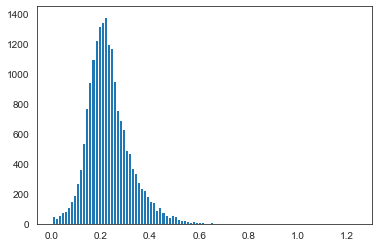

In [71]:
plt.hist(Z[Z > 0].cpu().detach().numpy(), 100);

In [72]:
thresh = 0.2

Z = F.relu(gnn(x_norm, adj_norm))
Z_pred = Z.cpu().detach().numpy() > thresh
model_saver.restore()
#print(f'Final nmi = {get_nmi(thresh):.3f}')

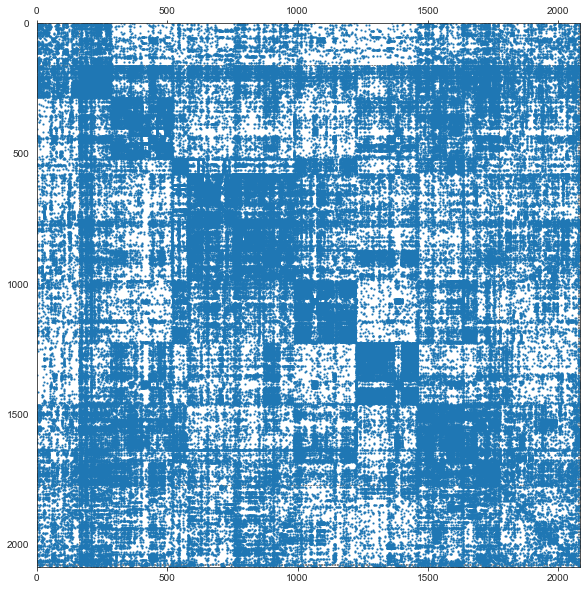

In [73]:
plt.figure(figsize=[10, 10])
z = np.argmax(Z_pred, 1)
o = np.argsort(z)
nocd.utils.plot_sparse_clustered_adjacency(A, K, z, o, markersize=1)

In [74]:
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

D:\GNN\overlapping-community-detection-master\nocd\metrics\unsupervised.py:29: RuntimeWarning: overflow encountered in long_scalars
  possible = (n - 2) * (n - 1) * n / 6


Predicted communities:
 - coverage    = 0.9510
 - conductance = 0.1948
 - density     = 9.216e-02
 - clust_coef  = -2.118e+00


In [75]:
print(Z_pred.sum(0))

[ 116 1611 1939 1844 1062 1110  888  892 1253  971]


In [78]:
np.savetxt('Z_pred.csv',Z_pred)

In [77]:
Z_pred

array([[False,  True, False, ...,  True,  True,  True],
       [False,  True, False, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       ...,
       [False,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True]])